# Laboratorio 02: Deep Learning

Construir un algoritmo de clasificación que sea capaz de reconocer dígitos escritos a mano. Para el entrenamiento se utilizará la base de datos MNIST.

Procedimiento:

1.   Cargar las librerías apropiadas
2.   Cargar la base de datos. Conjunto de entrenamiento y pruebas.
3.   Revisar las imágenes de la base de datos.
4.   Construir un modelo de redes neuronales apropiado.
5.   Probar si el modelo hace una estimación.
6.   Entrenar el modelo.
7.   Probar el modelo.

## 1. Cargar las librerías.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

## 2. Cargar la base de datos.

Cargar la base de datos utilizando la clase DataLoader. Construir un conjunto de datos para entrenamiento y otro para pruebas.

In [4]:
BATCH_SIZE = 32

# Transformacion PIL
transform = transforms.Compose([transforms.ToTensor()])

# Bajar la base de datos  y crear conjunto de entrenamiento
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Bajar la base de datos y crear conjunto de pruebas
testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3. Revisar las imágenes de la base de datos.

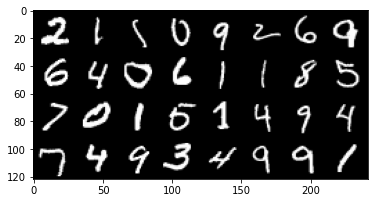

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(trainloader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))



In [10]:
# Iterar con for el trainloader
for indx, (images, labels) in enumerate(trainloader):
  print(f'Batch (lote): {indx}')
  print(images.shape)
  print(labels.shape)
  break


Batch (lote): 0
torch.Size([32, 1, 28, 28])
torch.Size([32])


## 4. Construir un modelo de redes neuronales apropiado.

In [12]:
class MiModelo(nn.Module):
  def __init__(self):
    super(MiModelo, self).__init__()
    # 28x28x1 ==>  26x26x32
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.d1 = nn.Linear(26 * 26 * 32, 128)
    self.d2 = nn.Linear(128, 10)

  def forward(self, x):
    # 32x1x28x28 ==> 32x32x26x26
    x = self.conv1(x)
    x = F.relu(x)

    # flatten ==> 32 x (32*25*25)
    x = x.flatten(start_dim=1)
    x = self.d1(x)
    x = F.relu(x)

    # logits ==> 32x10
    logits = self.d2(x)
    out = F.softmax(logits, dim=1)

    return out

## 5. Probar si el modelo hace una estimación.


In [21]:
# Probar si el modelo funciona
model = MiModelo()
for images, labels in trainloader:
  print('Tamaño del batch', images.shape)
  out = model(images)
  print(out.shape)
  break

Tamaño del batch torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## 6. Entrenar el modelo

In [23]:
learning_rate = 0.01
num_epoch = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiModelo()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
# Calcular tasa de acierto (accuracy)
def get_accuracy(logit, target, batch_size):
  ''' Obtener tasa de acierto para el conjunto de entrenamiento'''
  corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
  accuracy = (corrects/batch_size)*100.0
  return accuracy.item()


## Entrenamiento

In [25]:
for epoch in range(num_epoch):
  train_running_loss = 0.0
  train_acc = 0.0

  model = model.train()
  ## Etapa de entrenamiento
  for i, (images, labels) in enumerate(trainloader):
    
    # GPU
    images = images.to(device)
    labels = labels.to(device)

    # Forward + Backprop + loss
    logits = model(images)
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()

    # Actualizo los parametros del modelo
    optimizer.step()

    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(logits, labels, BATCH_SIZE)
  
  ## Calcular las metricas
  model = model.eval()
  print('Epoch: %d | Loss: %4f | Tasa de acierto de entrenamiento: %.2f' 
        % (epoch, train_running_loss/i, train_acc/i))


Epoch: 0 | Loss: 1.868011 | Tasa de acierto de entrenamiento: 68.96
Epoch: 1 | Loss: 1.583293 | Tasa de acierto de entrenamiento: 89.88
Epoch: 2 | Loss: 1.561923 | Tasa de acierto de entrenamiento: 91.19
Epoch: 3 | Loss: 1.552240 | Tasa de acierto de entrenamiento: 91.84
Epoch: 4 | Loss: 1.544993 | Tasa de acierto de entrenamiento: 92.43
Epoch: 5 | Loss: 1.539123 | Tasa de acierto de entrenamiento: 92.95
Epoch: 6 | Loss: 1.533869 | Tasa de acierto de entrenamiento: 93.46
Epoch: 7 | Loss: 1.529189 | Tasa de acierto de entrenamiento: 93.87
Epoch: 8 | Loss: 1.525437 | Tasa de acierto de entrenamiento: 94.24
Epoch: 9 | Loss: 1.521672 | Tasa de acierto de entrenamiento: 94.59


## 7. Probar el modelo

In [26]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader):
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Tasa de entrenamiento: %.2f' % (test_acc/i)) 

Tasa de entrenamiento: 94.72
